# Loss Function Variation in System Identification With Neural Networks
## Mohammad Qori Aziz Hakiki - 23222020


System Model:

$$y(k) = 1.37u(k) - 0.95u(k-1) + 3.2y(k-1) + 2.93 y(k-2)$$

### 1. Generate Input and Output For System

In [1]:
# import library
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# Import dataset for system
dataset = np.genfromtxt('data_motor_22Juni_ts100/1.txt',delimiter=';')
print(dataset)

# Get first column as input, skipping the header
input=torch.as_tensor(dataset[1:, 0], dtype=torch.float32)
input=torch.reshape(input, (len(input), 1))

# Normalize input
input = input / 10 

print(input)

[[      nan       nan       nan       nan]
 [ 1.        0.        0.        1.      ]
 [ 1.        1.06069   3.342621  1.      ]
 ...
 [ 0.       -0.046625  0.        0.      ]
 [ 0.       -0.298288  0.        0.      ]
 [ 0.       -0.298288  0.        0.      ]]
tensor([[0.1000],
        [0.1000],
        [0.1000],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])


In [3]:
# Generate output for system
output = torch.zeros((len(input),1))
print(output)

# Coefficient for our model. Each column corresponds to x(k), x(k-1), y(k-1), and y(k-2)
regressor = np.array([[1.37117312, -0.94887817, 3.1960358, 2.92779642]])
print(regressor)

 # Calculate output from our model
for i in range(len(output)):
    if i >= 0 :
        output[i] = regressor[0][0] * input[i]
        continue

    if i >= 1:
        output[i] =  regressor[0][0] * input[i] + regressor[0][1] * input[i-1] + regressor[0][2] * output[i-1]
        continue

    if i>=2 :
        output[i] =  regressor[0][0] * input[i] + regressor[0][1] * input[i-1] + regressor[0][2] * output[i-1] +  regressor[0][3] * output[i-2]

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
[[ 1.37117312 -0.94887817  3.1960358   2.92779642]]


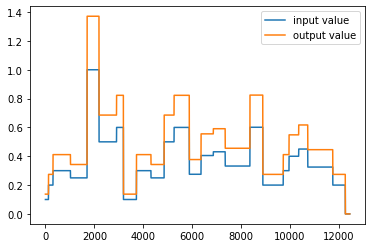

In [4]:
# Plot input and output 
input_det = input.detach().numpy()
output_det = output.detach().numpy()
plt.plot(input_det, label='input value')
plt.plot(output_det, label='output value')
plt.legend()

### 2. Parameter Estimation with Least Square Method

Here we apply time delay to our data. Suppose we predict that our DC motor transfer function will be like this:

$$H(z) = \frac{Y(z)}{U(z)} = \frac{b_{0} + b_{1}z^{-1}}{1 - a_{1}z^{-1} - a_{2}z^{-2}}$$

In time-domain, 

$$y(k) =a_{1}y(k-1) + a_{2}y(k-2) + b_{0}u(k) + b_{1}u(k-1)$$

Based on the reference paper, we will estimate the $a_{i}$ and $b_{j}$ parameter from the weight of the NN.  

To do so, the neural network inputs will be the delayed target output and inputs, in our case $y(k-1), y(k-2), u(k),$ and $u(k-1)$.


In [5]:
# Time delay block definition
def timedelayblock(input, target, inp_order, target_order):
    delayed_nn_input = input

    # Append delayed input
    for i in range(1, inp_order+1):
        concated_tensor =torch.roll(input, i, 0)
        for j in range(i):
            concated_tensor[j, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    
    # Append delayed input
    for k in range(1, target_order+1):
        concated_tensor = torch.roll(target, k, 0)
        for l in range(k):
            concated_tensor[l, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    return delayed_nn_input

# Initialize system order
inp_order = 1
out_order = 2
# Create x(k), x(k-1), y(k-1), and y(k-2)
nn_input= timedelayblock(input, output, inp_order, out_order)
print(nn_input[0:5, :])
print(nn_input.size())

tensor([[0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1371, 0.0000],
        [0.1000, 0.1000, 0.1371, 0.1371],
        [0.1000, 0.1000, 0.1371, 0.1371],
        [0.1000, 0.1000, 0.1371, 0.1371]])
torch.Size([12450, 4])


In [6]:
# Split training and test data
nn_input_train = nn_input[:10000, :]
nn_input_test = nn_input[10000:, :]

y_train =output[:10000, :]
y_test = output[10000:, :]

print(torch.sum(y_train))

tensor(5267.9521)


#### Define the NN model that will be used.  
Here we will add hidden layer and act function based on the parameters provided.

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_dim, hidden_layer, out_classes):
        super(NeuralNetwork, self).__init__()
        # Create ordered Dictionary based on the number of hidden_layer
        sequence = OrderedDict()
        for layer in range(hidden_layer):
            if layer == 0:
                sequence['hidden_layer_{}'.format(layer)] =nn.Linear(
                    in_features, hidden_dim, bias=False)
                sequence['activation_{}'.format(layer)] =  nn.Tanh()
                continue
            # For layer not in the input layer
            sequence['hidden_layer_{}'.format(layer)] = nn.Linear(
                hidden_dim, hidden_dim, bias=False)
            sequence['activation_{}'.format(layer)] = nn.Tanh()
        # Insert output layer
        sequence['output_layer'] = nn.Linear(hidden_dim, out_classes, bias=False)

        # print(sequence)
        # return the sequential model
        self.layer_stack = nn.Sequential(sequence)
        

    def forward(self, x):
        x = self.layer_stack(x)
        return x

In [8]:
# Variable declaration
# Since we have u(k), u(k-1), y(k-1), and y(k-2), we have 4 inputs.

in_features=inp_order + out_order +1  # how many Variables are in the dataset
hidden_dim= inp_order + out_order +1 # hidden i/o
hidden_layer=5 # how many hidden layers
output_dim= 1   # number of classes
epoch = 100 

In [9]:
clf=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(clf)

params = clf.parameters()
# print(len(params))

for p in params:
    print(p.size())  # conv1's .weight
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (hidden_layer_3): Linear(in_features=4, out_features=4, bias=False)
    (activation_3): Tanh()
    (hidden_layer_4): Linear(in_features=4, out_features=4, bias=False)
    (activation_4): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.4218, -0.0947,  0.0881,  0.4806],
        [-0.1259,  0.4940, -0.1679, -0.3133],
        [-0.2779, -0.4735,  0.3084, -0.0733],
        [-0.1121,  0.3473, -0.3888, -0.3633]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.1079,  0.1043,  0.2923,  0.2825],
        [ 0.1328, -0.1897,  0.4050, -0.1291],
      

#### Compute Weight and Bias

##### Initialize loss and optimizer

In [10]:
# # Construct least square loss function for learning
# from logging import critical


# class LeastSquareLoss(nn.Module):
#     def __init__(self):
#         super(LeastSquareLoss, self).__init__()
 
#     def forward(self, inputs, targets):
#         difference = targets - inputs
#         loss_value = torch.sum(difference**2)
#         return loss_value


# criterion = LeastSquareLoss()
criterion = nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(clf.parameters(), lr = 0.3)

In [11]:
for e in range(epoch):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = clf(nn_input_train)

   # Compute and print loss
   loss = criterion(y_pred, y_train)
   print('epoch: ', e,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.35420018434524536
epoch:  1  loss:  0.3532670736312866
epoch:  2  loss:  0.35244640707969666
epoch:  3  loss:  0.35170412063598633
epoch:  4  loss:  0.35101318359375
epoch:  5  loss:  0.35035109519958496
epoch:  6  loss:  0.3496984541416168
epoch:  7  loss:  0.3490374982357025
epoch:  8  loss:  0.34835100173950195
epoch:  9  loss:  0.34762144088745117
epoch:  10  loss:  0.34682977199554443
epoch:  11  loss:  0.34595465660095215
epoch:  12  loss:  0.3449709117412567
epoch:  13  loss:  0.3438478112220764
epoch:  14  loss:  0.342547208070755
epoch:  15  loss:  0.3410203754901886
epoch:  16  loss:  0.3392036557197571
epoch:  17  loss:  0.33701270818710327
epoch:  18  loss:  0.334333598613739
epoch:  19  loss:  0.3310098946094513
epoch:  20  loss:  0.32682281732559204
epoch:  21  loss:  0.321461945772171
epoch:  22  loss:  0.3144795298576355
epoch:  23  loss:  0.30522283911705017
epoch:  24  loss:  0.29273709654808044
epoch:  25  loss:  0.2756461501121521
epoch:  26  los

In [12]:
for param in clf.parameters():
   print(param)

# Loss testing
y_pred_test = clf(nn_input_test)
print(y_pred_test)
loss = criterion(y_pred_test, y_test)
print(' loss: ', loss.item())

Parameter containing:
tensor([[ 0.3933, -0.1248,  0.0468,  0.4374],
        [-0.1726,  0.4487, -0.2300, -0.3736],
        [-0.3015, -0.4954,  0.2783, -0.1015],
        [-0.0807,  0.3798, -0.3443, -0.3175]], requires_grad=True)
Parameter containing:
tensor([[-0.0571,  0.1887,  0.4115,  0.4298],
        [ 0.0998, -0.1792,  0.4220, -0.1034],
        [-0.4771, -0.2955, -0.4695,  0.0524],
        [ 0.5478, -0.2416, -0.0197,  0.1384]], requires_grad=True)
Parameter containing:
tensor([[-0.2602,  0.2859, -0.2318,  0.1604],
        [ 0.3257, -0.1222, -0.0674,  0.2628],
        [ 0.6062,  0.3185,  0.0973, -0.5226],
        [-0.4252,  0.3587,  0.4640,  0.3279]], requires_grad=True)
Parameter containing:
tensor([[ 0.0020,  0.0774,  0.6766, -0.4397],
        [-0.0356, -0.1059,  0.2232, -0.1057],
        [ 0.5954, -0.2614, -0.5636, -0.0008],
        [ 0.1817, -0.4229,  0.6175, -0.3845]], requires_grad=True)
Parameter containing:
tensor([[-0.1134, -0.1432,  0.1464, -0.3318],
        [ 0.6696,  0.155

tensor([[0.5879],
        [0.5879],
        [0.5879],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<MmBackward0>)


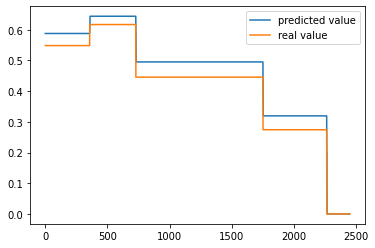

In [13]:
# Print test data
nn_input_test = nn_input_test.detach().numpy()

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

##### Transform NN Weights to Transfer Function

In here, we define an NN2TF algorithm. Based on the reference paper, the parameter $a_{j}$ and $b_{i}$ can be estimated by

$$a_{j} = (\sum_{h=1}^H (wout_{h}v_{jh}))$$

$$b_{i} = (\sum_{h=1}^H (wout_{h}w_{ih}))$$

For tanh activation function.

In [14]:
def nn2tf(nn, hidden_layer, inp_order, target_order):
    regressor = np.zeros((1, inp_order+target_order+1))
    wout = nn.state_dict()['layer_stack.output_layer.weight']
    wout = wout.numpy()
    print('wout : ', wout)
    # print(wout.size())
    params = nn.named_parameters()
    i = 0
    for p in params:
        # print(p)

        w_hidden = nn.state_dict()['layer_stack.hidden_layer_{}.weight'.format(i)]
        w_hidden = w_hidden.numpy()
        print('w_hidden : ', w_hidden)
        # Update regressor
        regressor = regressor + (wout @ w_hidden)
        print(regressor)

        i = i + 1
        if i == hidden_layer :
            break
    
    # regressor = regressor * 0.5
    return regressor


regressor = nn2tf(clf, hidden_layer, inp_order, out_order)
print(regressor)

wout :  [[ 0.39981672 -1.0439909  -0.59528184 -0.19258848]]
w_hidden :  [[ 0.39325312 -0.12478405  0.04681564  0.4374461 ]
 [-0.17255887  0.44868603 -0.22996823 -0.3736275 ]
 [-0.30151677 -0.495443    0.27828574 -0.10146509]
 [-0.0807237   0.37977374 -0.3442879  -0.31753105]]
[[ 0.53241295 -0.2965267   0.15944985  0.68651509]]
w_hidden :  [[-0.05708325  0.18872702  0.41150984  0.429754  ]
 [ 0.09983957 -0.17915311  0.42204148 -0.10338955]
 [-0.4771312  -0.29548934 -0.4694584   0.05235504]
 [ 0.54780936 -0.24162257 -0.01971976  0.13838363]]
[[0.58388427 0.1883969  0.16662881 0.90845858]]
w_hidden :  [[-0.26017955  0.2859131  -0.23178199  0.16037527]
 [ 0.32566702 -0.1222184  -0.06736907  0.26276287]
 [ 0.60615337  0.3185219   0.097348   -0.5226161 ]
 [-0.42523763  0.358738    0.46404234  0.32787743]]
[[-0.13906953  0.17160553 -0.00302753  0.9462157 ]]
w_hidden :  [[ 0.00198047  0.07743173  0.6765919  -0.43971193]
 [-0.03558238 -0.1059286   0.22324131 -0.10572744]
 [ 0.59535074 -0.261353

In [15]:
# Calculate estimated output from our model
y_pred = np.zeros((len(output),1))

nn_input_detach = nn_input.detach().numpy()

for i in range(len(output)):
    if i == 0 :
        y_pred[i] = regressor[0][0] * nn_input_detach[i][0]
        continue
    
    # Fill y(k-1)
    if i >= 1 :
        nn_input_detach[i][2] = y_pred[i-1]
    
        # Fill y(k-2)
    if i >=2 :
        nn_input_detach[i][3] = y_pred[i-2]

    for j in range (len(regressor)):
        y_pred[i] += regressor[0][j] * nn_input_detach[i][j]

[[-0.17033757]
 [-0.17033757]
 [-0.17033757]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


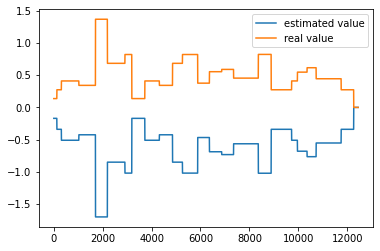

In [16]:
# Plot estimated output

print(y_pred)
plt.plot(y_pred, label='estimated value')
plt.plot(output, label='real value')
leg = plt.legend()

### 3. Estimate Parameter with Genetic Algorithm, Simulated Annealing, and Particle Swarm Opt

#### a. Simulated Annealing

Here we won't redefine delayed input and nn, since we assume the order are the same with the previous method.

In [17]:
## Initialize input and output
# Split training and test data
nn_ga_train = nn_input[:10000, :]
nn_ga_test = nn_input[10000:, :]

y_ga_train =output[:10000, :]
y_ga_test = output[10000:, :]

In [18]:
# Create Network
network=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(network)

params = network.parameters()
# print(len(params))

for p in params:
    print(p.size())
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (hidden_layer_3): Linear(in_features=4, out_features=4, bias=False)
    (activation_3): Tanh()
    (hidden_layer_4): Linear(in_features=4, out_features=4, bias=False)
    (activation_4): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.1138, -0.1938,  0.3749, -0.3444],
        [ 0.3383,  0.2388, -0.4416, -0.3578],
        [-0.0101, -0.2174,  0.0132, -0.4758],
        [ 0.3948,  0.0945,  0.1299, -0.2483]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.4006,  0.0875,  0.4658,  0.3825],
        [-0.1618,  0.2342,  0.1286, -0.0029],
      

#### Compute Weight and Bias

##### Define Simulated Annealing Optimizer and Initialize

Here we define SimulatedAnnealing class as Optimizer, to ensure we can use it as weight and bias updating function below.

In [19]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import numpy as np
import math
import random

class SimulatedAnnealing(Optimizer):
    def __init__(self, neighborhoodSize = 0.5
                 , loss = nn.MSELoss()
                 , model = None
                 , features = None
                 , labels = None
                 , bounds= None
                 , initTemp= None
                 , finalTemp = 0): #these represent default values, but can be overridden
        self.loss = loss
        self.model = model
        self.bounds = bounds
        self.features = features
        self.labels = labels
        self.neighborhoodSize = neighborhoodSize
        self.currTemp = initTemp
        self.finalTemp = finalTemp
        self.iterPerTemp = 5
        self.stepTemp = 0.01

    def step(self):
        #need to first generate a random new point in the space
        oldOutputs = self.model(self.features)
        oldLoss = self.loss(oldOutputs, self.labels.type(torch.LongTensor))
        # Save init values
        old_state_dict = {}
        for key in self.model.state_dict():
            old_state_dict[key] = self.model.state_dict()[key].clone()

        for name, param in self.model.state_dict().items():
            for i in range(self.iterPerTemp):
            #generate a matrix of random changes in each param element to be added to each param matrix
                if (len(param.shape) == 2):
                    random = torch.Tensor(np.random.uniform(low = self.bounds[0][0], high =self.bounds[0][1]
                                                            , size = (param.shape[0], param.shape[1])))
                else:
                    random = torch.Tensor(np.random.uniform(low = self.bounds[0][0], high = self.bounds[0][1]
                                                            , size = param.shape[0]))
                #now add random to the params to transform them
                new_param = param + random * self.neighborhoodSize

                # Insert new parameter to model for calculating new loss
                self.model.state_dict()[name].copy_(new_param)

                newOutputs = self.model(self.features)
                newWeights = self.model.state_dict().items()
                newLoss = self.loss(newOutputs, self.labels.type(torch.LongTensor))

                self.model.load_state_dict(old_state_dict)

                if (newLoss  < oldLoss):
                     self.model.state_dict()[name].copy_(new_param)
                else:
                    if np.random.random() < math.exp(-(newLoss-oldLoss) / self.currTemp):
                        self.model.state_dict()[name].copy_(new_param)

        # Descent the temperature linearly
        self.currTemp -= self.stepTemp
        print(self.currTemp)

In [20]:
lossFunc =  nn.MSELoss()
optimizer = SimulatedAnnealing(loss = lossFunc, model=network, features=nn_ga_train, labels=y_ga_train, bounds = torch.tensor([[-5, 5]]), initTemp = 5)
epoch = 500
for e in range(epoch):

   # Forward pass: Computed predicted y by passing x to the model
   y_pred = network(nn_ga_train)

   # Compute and print loss
   loss = lossFunc(y_pred, y_ga_train)

   # Define termination criteria
   if (optimizer.currTemp-0.00005 <= optimizer.finalTemp) or (loss < 0.005):
      break
   print('epoch: ', e,' loss: ', loss.item())

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.33424636721611023
4.99
epoch:  1  loss:  0.44187119603157043
4.98
epoch:  2  loss:  0.3280602991580963
4.970000000000001
epoch:  3  loss:  0.3795114755630493
4.960000000000001
epoch:  4  loss:  0.04314601793885231
4.950000000000001
epoch:  5  loss:  0.010391566902399063
4.940000000000001
epoch:  6  loss:  0.08082666993141174
4.9300000000000015
epoch:  7  loss:  0.18342627584934235
4.920000000000002
epoch:  8  loss:  0.053399402648210526
4.910000000000002
epoch:  9  loss:  0.06350439786911011
4.900000000000002
epoch:  10  loss:  0.0693386048078537
4.890000000000002
epoch:  11  loss:  0.08548677712678909
4.880000000000003
epoch:  12  loss:  0.07278413325548172
4.870000000000003
epoch:  13  loss:  0.09103328734636307
4.860000000000003
epoch:  14  loss:  0.041625916957855225
4.850000000000003
epoch:  15  loss:  0.03795421123504639
4.840000000000003
epoch:  16  loss:  0.11831728368997574
4.830000000000004
epoch:  17  loss:  0.04281052201986313
4.820000000000004
epoch:  1

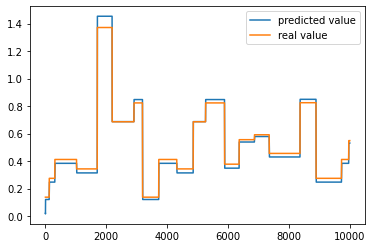

In [21]:
# print train data
y_pred_train = network(nn_ga_train)
y_pred_train_detach = y_pred_train.detach().numpy()

y_train = y_ga_train.detach().numpy()
plt.plot(y_pred_train_detach, label='predicted value')
plt.plot(y_train, label='real value')
plt.legend()

tensor([[0.5307],
        [0.5307],
        [0.5307],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<MmBackward0>)


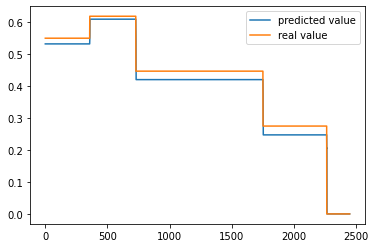

In [22]:
# Print test data
y_pred_test = network(nn_ga_test)

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_ga_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

#### Transform to Transfer Function

Using the same algorithm with NN2TF block before

In [23]:
regressor = nn2tf(network, hidden_layer, inp_order, out_order)
print(regressor)

wout :  [[ 0.83614206 20.702602   36.3743     33.897022  ]]
w_hidden :  [[ 0.11375511 -0.19383758  0.37486225 -0.3443653 ]
 [ 0.33826703  0.23877817 -0.4416027  -0.35780603]
 [-0.01010942 -0.21737951  0.01317382 -0.4758219 ]
 [ 0.39476162  0.09451377  0.12991202 -0.24834889]]
[[ 20.11164284   0.07796192  -3.94606829 -33.4214325 ]]
w_hidden :  [[-0.40059263  0.08753657  0.46584707  0.38245088]
 [-0.161785    0.23416317  0.12863636 -0.00286621]
 [-0.30257612 -0.23965704  0.46855742  0.35077655]
 [ 0.15699083  0.16662562 -0.0448032   0.07418913]]
[[ 10.74284744   1.92969704  14.63130713 -17.88694572]]
w_hidden :  [[-0.04838669  0.0791617  -0.08310121 -0.4834683 ]
 [-0.31704217 -0.18688852  0.07810891 -0.11592835]
 [-0.18588263  0.31734043 -0.42610556  0.11177754]
 [ 0.29783165  0.4273532   0.09208035 -0.3698113 ]]
[[  7.47304726  24.15584564   3.8008399  -29.16088486]]
w_hidden :  [[-0.09324932  0.06876355  0.2049222   0.0444172 ]
 [-0.28713268 -0.07800514 -0.47893405  0.38224727]
 [ 0.18

In [24]:
# Calculate estimated output from transfer function
y_pred_tf1 = np.zeros((len(y_ga_test),1))

nn_ga_test_detach = nn_ga_test.detach().numpy()

for i in range(len(y_ga_test)):
    if i == 0 :
        y_pred_tf1[i] = regressor[0][0] * nn_ga_test_detach[i][0]
        continue
    
    # Fill y(k-1)
    if i >= 1 :
        nn_ga_test_detach[i][2] = y_pred[i-1]
    
    # Fill y(k-2)
    if i >=2 :
        nn_ga_test_detach[i][3] = y_pred[i-2]

    for j in range (len(regressor)):
        y_pred_tf1[i] += regressor[0][j] * nn_ga_test_detach[i][j]

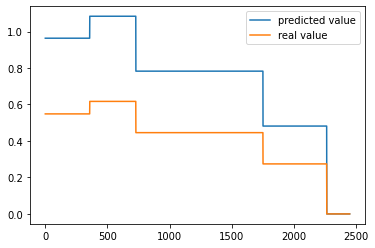

In [25]:
# Print test dat

y_test = y_ga_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_tf1, label='predicted value')
plt.plot(y_test, label='real value')
plt.legend()

In [26]:
# # simulated annealing search of a one-dimensional objective function
# from numpy import asarray
# from numpy import exp
# from numpy.random import randn
# from numpy.random import rand
# from numpy.random import seed
# from matplotlib import pyplot
# import random
 
# # objective function
# def objective(x):
# 	return x[0]**2.0
 
# # simulated annealing algorithm
# def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
# 	# generate an initial point
# 	best = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
# 	# evaluate the initial point
# 	best_eval = objective(best)
# 	print(best_eval)
# 	# current working solution
# 	curr, curr_eval = best, best_eval
# 	scores = list()
# 	# run the algorithm
# 	for i in range(n_iterations):
# 		# take a step
# 		candidate = curr + randn(len(bounds)) * step_size
# 		# evaluate candidate point
# 		candidate_eval = objective(candidate)
# 		# check for new best solution
# 		if candidate_eval < best_eval:
# 			# store new best point
# 			best, best_eval = candidate, candidate_eval
# 			# keep track of scores
# 			scores.append(best_eval)
# 			# report progress
# 			print('>%d f(%s) = %.5f' % (i, best, best_eval))
# 		# difference between candidate and current point evaluation
# 		diff = candidate_eval - curr_eval
# 		# calculate temperature for current epoch
# 		t = temp / float(i + 1)
# 		# calculate metropolis acceptance criterion
# 		metropolis = exp(-diff / t)
# 		# check if we should keep the new point
# 		if diff < 0 or rand() < metropolis:
# 			# store the new current point
# 			curr, curr_eval = candidate, candidate_eval
# 	return [best, best_eval, scores]
 
# # seed the pseudorandom number generator
# seed(1)
# # define range for input
# bounds = asarray([[0.0, 1.5]])
# print(bounds)
# # define the total iterations
# n_iterations = 1000
# # define the maximum step size
# step_size = 0.1
# # initial temperature
# temp = 10
# # perform the simulated annealing search
# best, score, scores = simulated_annealing(objective, bounds, n_iterations, step_size, temp)
# print('Done!')
# print('f(%s) = %f' % (best, score))
# # line plot of best scores
# pyplot.plot(scores, '.-')
# pyplot.xlabel('Improvement Number')
# pyplot.ylabel('Evaluation f(x)')
# pyplot.show()